In [1]:
import matplotlib.pyplot as plt
import numpy as np
import allel
import os
from numpy.lib.stride_tricks import sliding_window_view

from sai.stats.scct_feature import *


### This notebook applies the cross-SCCT statistic (different variants) to the reference and target population. It seems that the algorithm which computes the counts for ancestral and derived for both populations, the computes the log-ratio for both ancestral counts and both derived counts and finally returns the maximum, performs best.
### The section '## Show values for ancestral and derived SCCT between both populations' also shows how these two group-SCCT values behave along the chromosome.
### Two other variants - either compute SSCT as usual, separately for both populations, and subsequently compute the log-ratio of this log-ratio or do the counting for both populations and then take the max-value of the counts for a SSCT-computation (log-ratio) betweem the populations, usually does not give a reasonable result.
### At the end of the notebook, another approach has been used: Simply compute the SSCT separately for both populations and finally calculate the difference. Also this works well for the example.
### However, it would be crucial to test it on other data sets.

In [2]:

vcf_chr9 = os.path.join("examples", "data", "1KG.nea_den.chr9.example.vcf.gz")
ref_ind_file = os.path.join("examples", "data", "1KG.ref.samples.txt")
tgt_ind_file = os.path.join("examples", "data", "1KG.tgt.samples.txt")
src_ind_file = os.path.join("examples", "data", "1KG.src.samples.txt")


In [3]:
vcf_file_allel = allel.read_vcf(vcf_chr9)

In [4]:
genotypes = vcf_file_allel['calldata/GT']
genotype_array = allel.GenotypeArray(genotypes)


In [5]:
anc_allele_file = None
win_len = 50000
win_step = 50000
chr_name = "9"
vcf_file = vcf_chr9
ploidy = 2

In [6]:
is_phased = True

In [7]:
full_vcf = load_full_vcf(vcf_file, "9", ref_ind_file, tgt_ind_file, src_ind_file=src_ind_file, ploidy=2, is_phased=True)
full_vcf_ref_gts = full_vcf[0]
full_vcf_tgt_gts = full_vcf[2]
full_vcf_positions = full_vcf[-1]

In [8]:
filtered_vcf = filter_zero_rows_multi(full_vcf_tgt_gts, full_vcf_ref_gts, return_indices=True)
full_vcf_tgt_gts_filtered = filtered_vcf[0][0]
full_vcf_ref_gts_filtered = filtered_vcf[0][1]
full_indices_filtered = filtered_vcf[1]
full_vcf_pos_filtered = np.delete(full_vcf_positions, full_indices_filtered, axis=0)

In [9]:
full_vcf_tgt_gts_filtered.shape

(1613, 1006)

In [10]:
full_vcf_ref_gts_filtered.shape

(1613, 2016)

# Unstandardized results

## raw counts

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

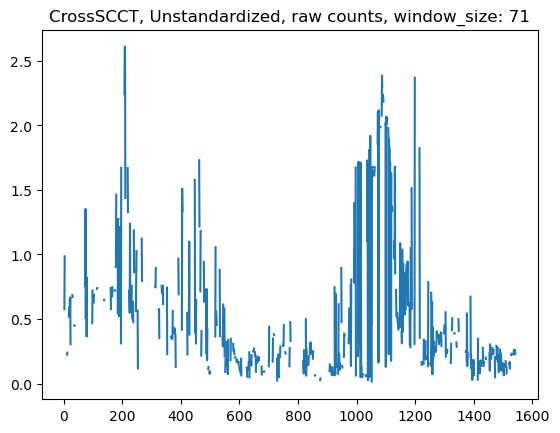

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, raw counts, window_size: 71, smoothed average with window_size 100 \n cross-SCCT')

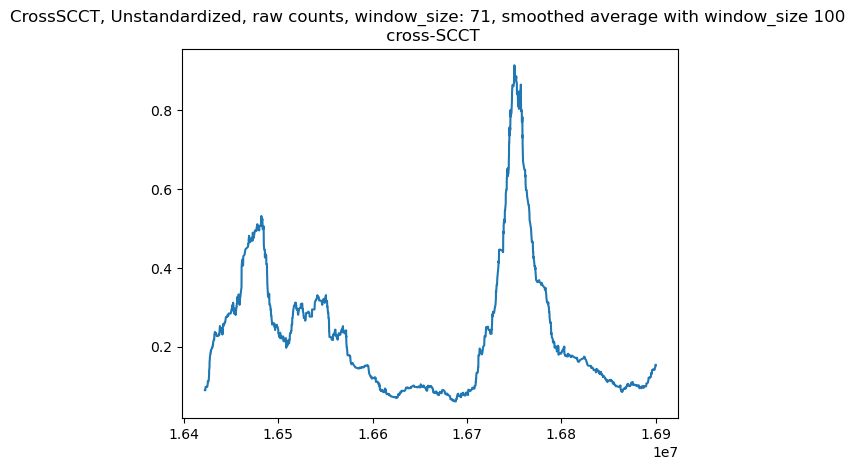

In [11]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered,  set_alpha_1=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, raw counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, raw counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n cross-SCCT")

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

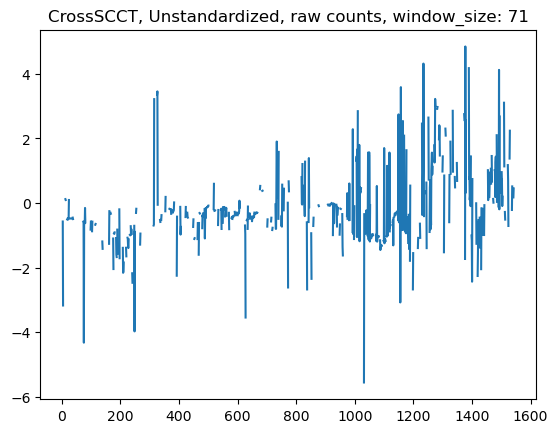

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, raw counts, window_size: 71, smoothed average with window_size 100 \n log_ratio_of_log_ratios-SCCT')

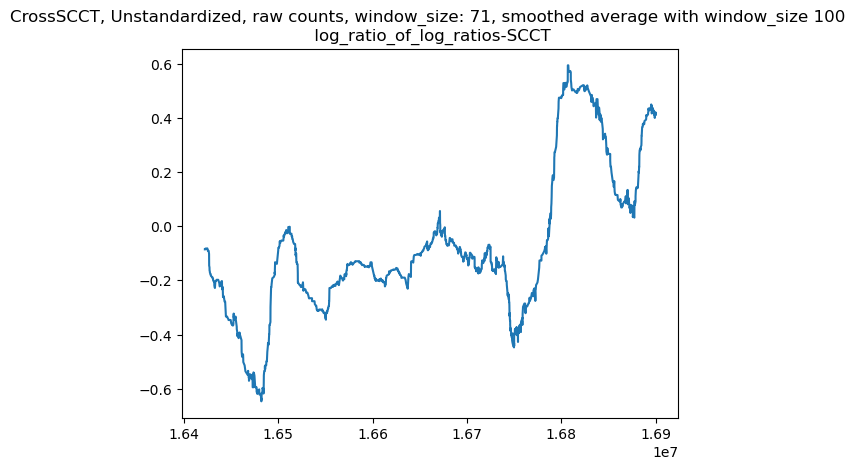

In [12]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, log_ratio_of_log_ratios=True, set_alpha_1=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, raw counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, raw counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n log_ratio_of_log_ratios-SCCT")

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

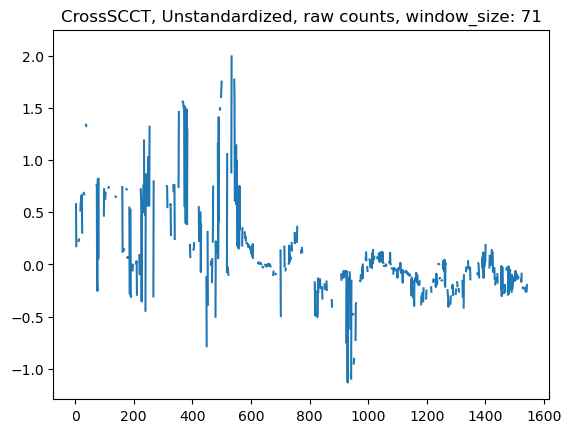

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, raw counts, window_size: 71, smoothed average with window_size 100 \n simple max cross-SCCT')

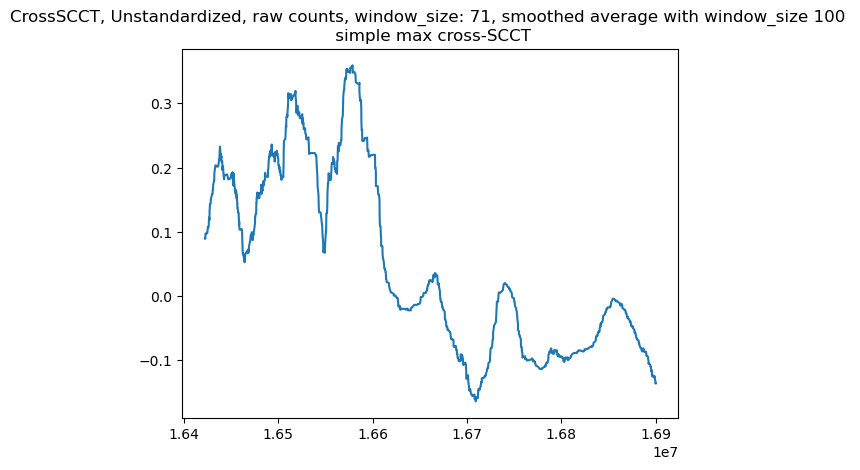

In [13]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, simple_max=True, set_alpha_1=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, raw counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, raw counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n simple max cross-SCCT")

## full log counts (with Yates-correction)

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan


/home/jalh/Desktop/pyscct/scct/scct.py:287: RuntimeWarning: divide by zero encountered in log
  S = np.log(sum_D / (ratio_alpha * sum_C))
/home/jalh/Desktop/pyscct/scct/scct.py:287: RuntimeWarning: divide by zero encountered in scalar divide
  S = np.log(sum_D / (ratio_alpha * sum_C))


Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan


/home/jalh/Desktop/pyscct/scct/scct.py:287: RuntimeWarning: invalid value encountered in scalar divide
  S = np.log(sum_D / (ratio_alpha * sum_C))


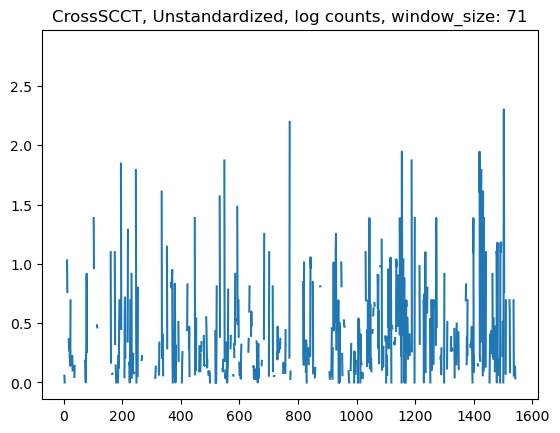

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, log counts, window_size: 71, smoothed average with window_size 100 \n cross-SCCT')

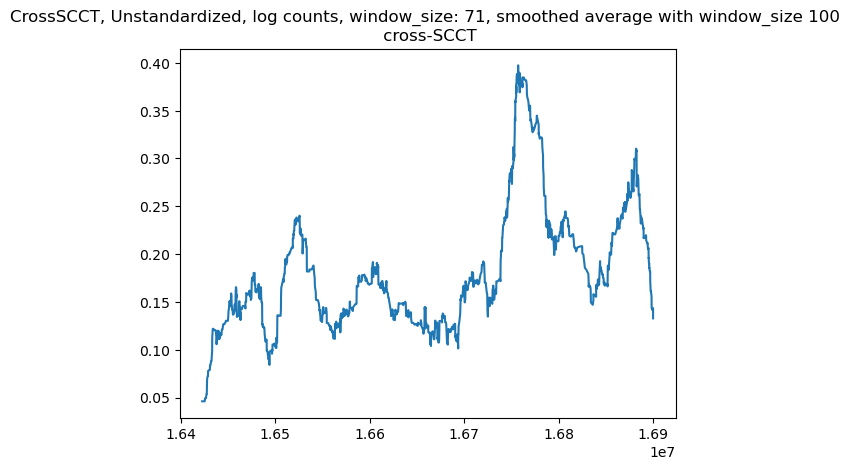

In [14]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered,  use_log_ratio=True, set_alpha_1=True)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n cross-SCCT")

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan


/home/jalh/Desktop/pyscct/scct/scct.py:1033: RuntimeWarning: divide by zero encountered in log
  cross_SCCT = np.log(abs(SCCT1) / abs(SCCT2))
/home/jalh/Desktop/pyscct/scct/scct.py:1033: RuntimeWarning: divide by zero encountered in scalar divide
  cross_SCCT = np.log(abs(SCCT1) / abs(SCCT2))


Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan


/home/jalh/Desktop/pyscct/scct/scct.py:1033: RuntimeWarning: invalid value encountered in scalar divide
  cross_SCCT = np.log(abs(SCCT1) / abs(SCCT2))


Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

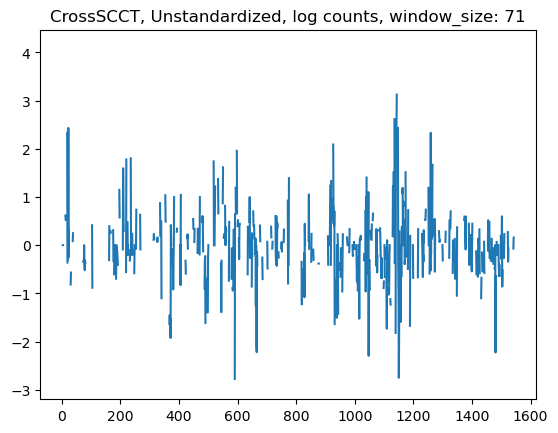

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, log counts, window_size: 71, smoothed average with window_size 100 \n log_ratio_of_log_ratios-SCCT')

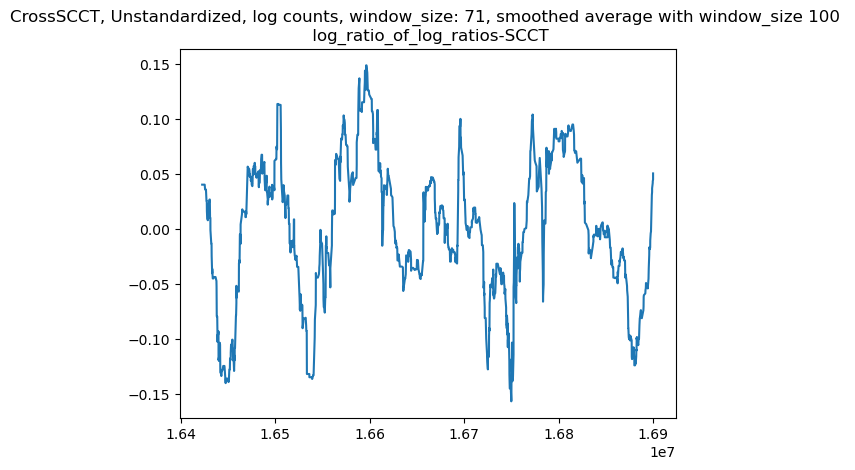

In [15]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, log_ratio_of_log_ratios=True, use_log_ratio=True, set_alpha_1=True)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n log_ratio_of_log_ratios-SCCT")

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

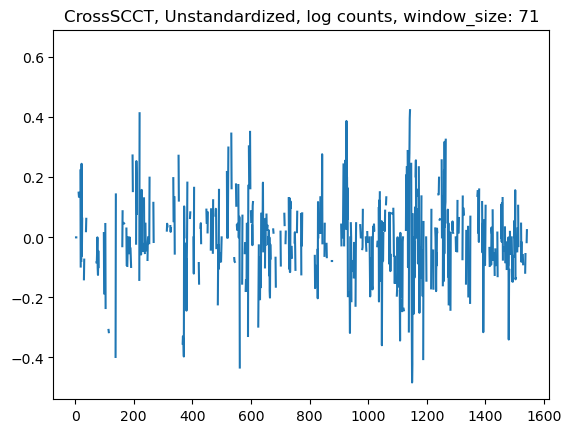

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, log counts, window_size: 71, smoothed average with window_size 100 \n simple max cross-SCCT')

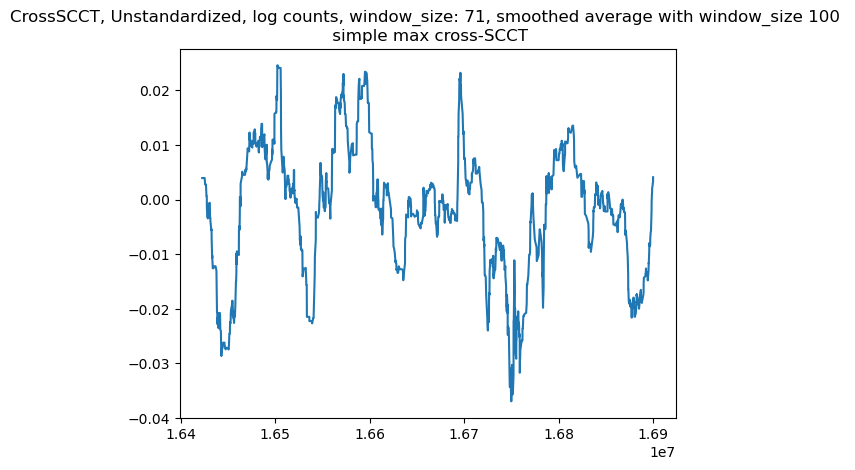

In [16]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, simple_max=True,  use_log_ratio=True, set_alpha_1=True)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n simple max cross-SCCT")

## simple log counts

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

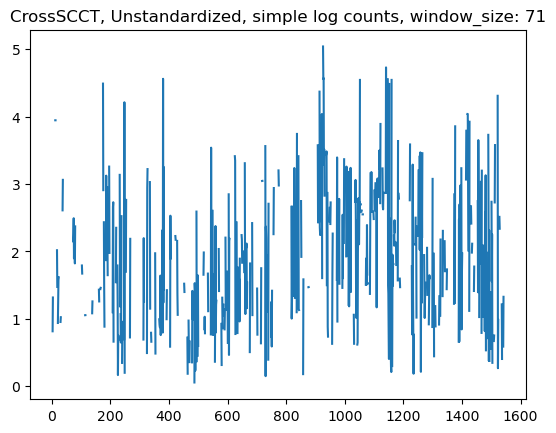

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, simple log counts, window_size: 71, smoothed average with window_size 100 \n cross-SCCT')

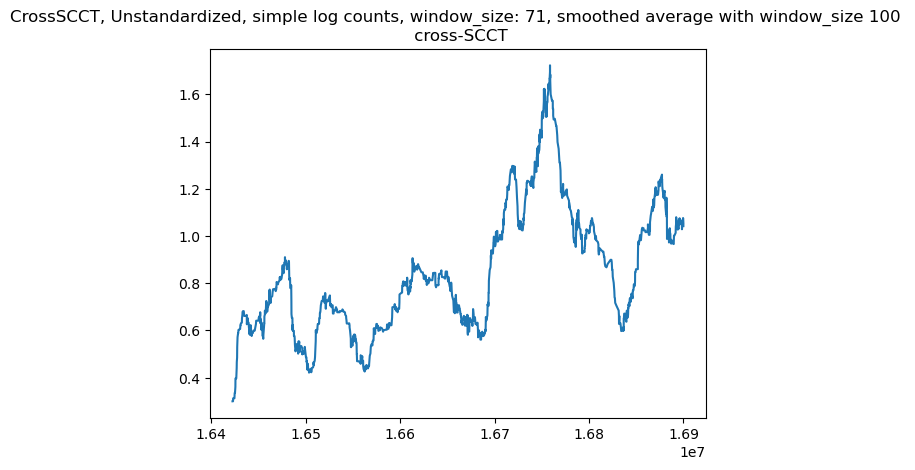

In [17]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered,  use_log_ratio=True, simple_log_ratio=True, set_alpha_1=True)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, simple log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, simple log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n cross-SCCT")

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

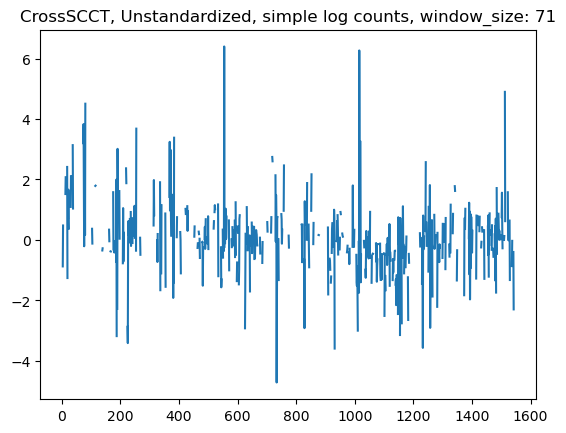

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, simple log counts, window_size: 71, smoothed average with window_size 100 \n log_ratio_of_log_ratios-SCCT')

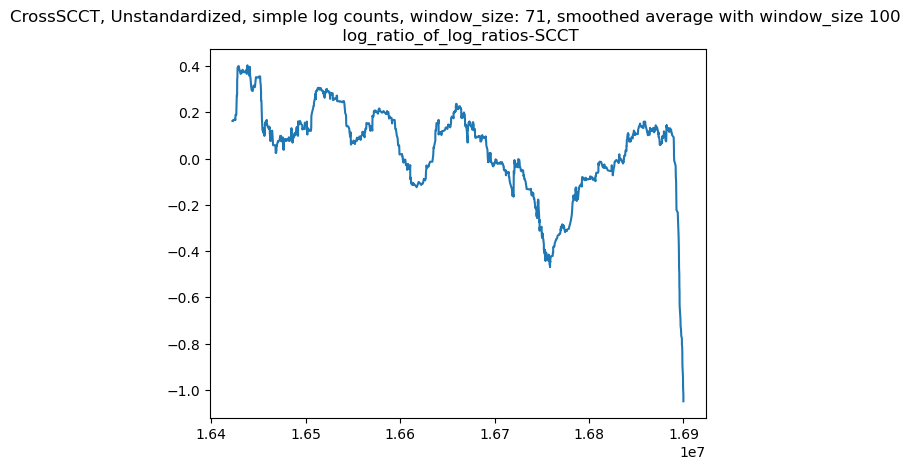

In [18]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, log_ratio_of_log_ratios=True, use_log_ratio=True, simple_log_ratio=True, set_alpha_1=True)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, simple log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, simple log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n log_ratio_of_log_ratios-SCCT")

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

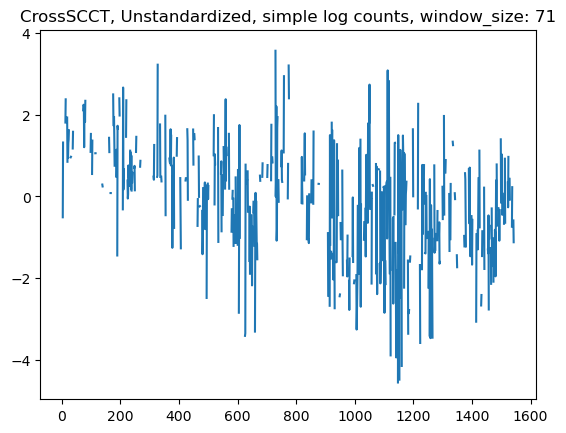

Text(0.5, 1.0, 'CrossSCCT, Unstandardized, simple log counts, window_size: 71, smoothed average with window_size 100 \n simple max cross-SCCT')

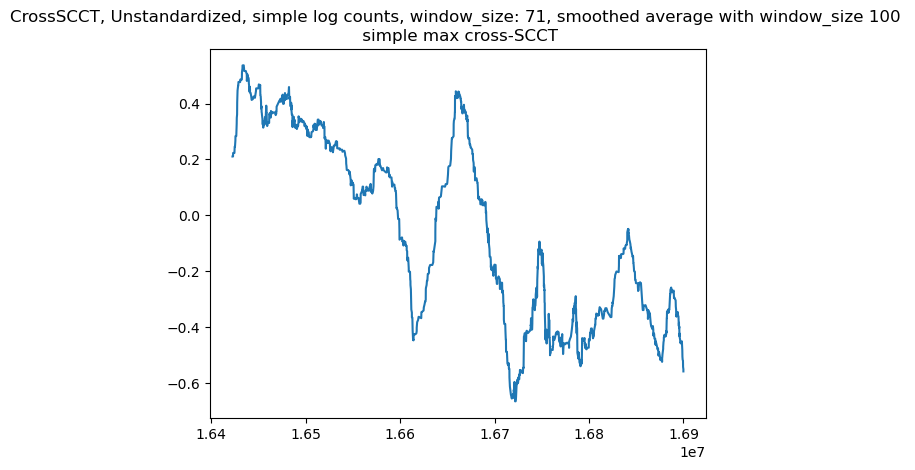

In [19]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, simple_max=True,  use_log_ratio=True, simple_log_ratio=True, set_alpha_1=True)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, Unstandardized, simple log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, Unstandardized, simple log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n simple max cross-SCCT")

# Empirical alpha ratio

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

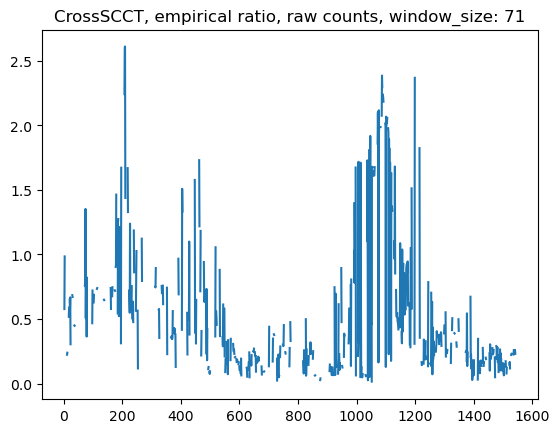

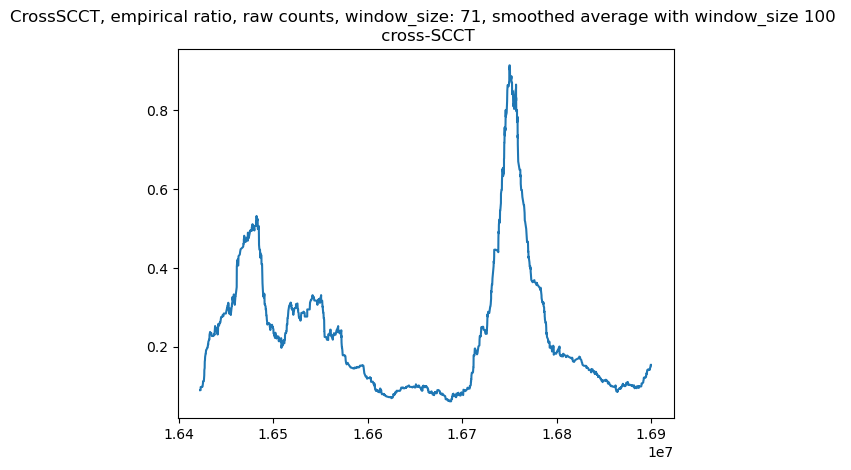

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

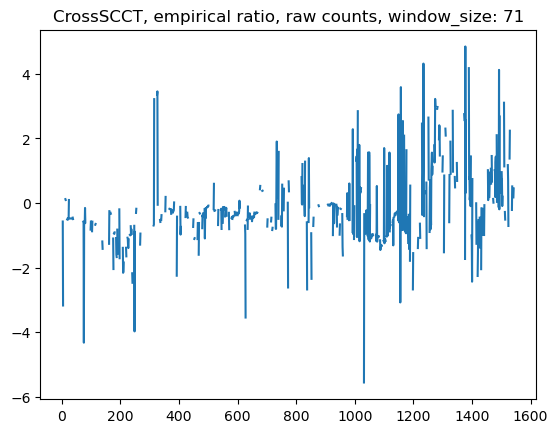

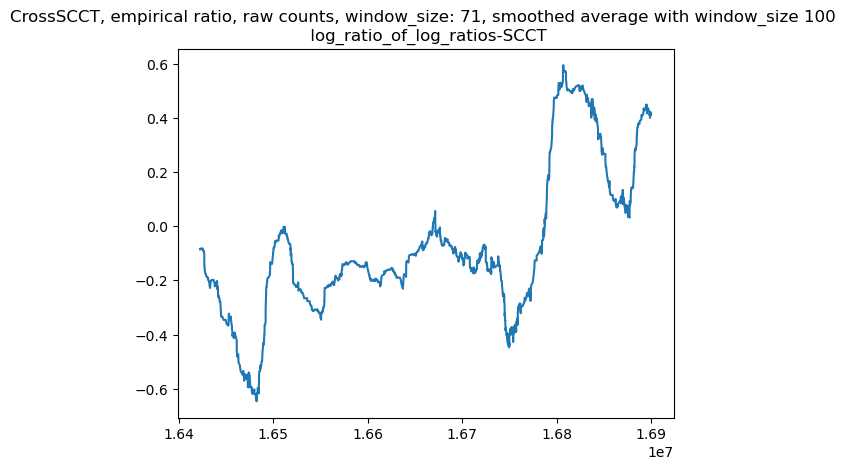

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

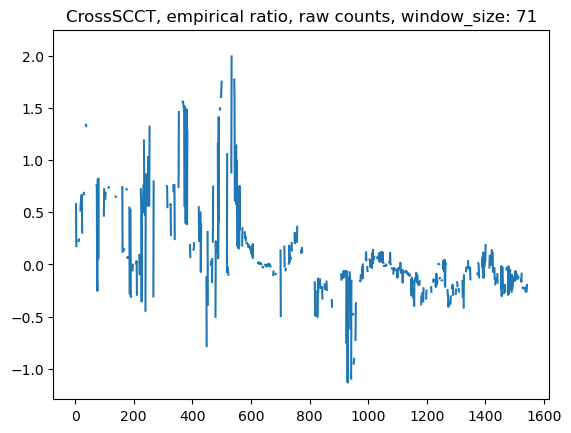

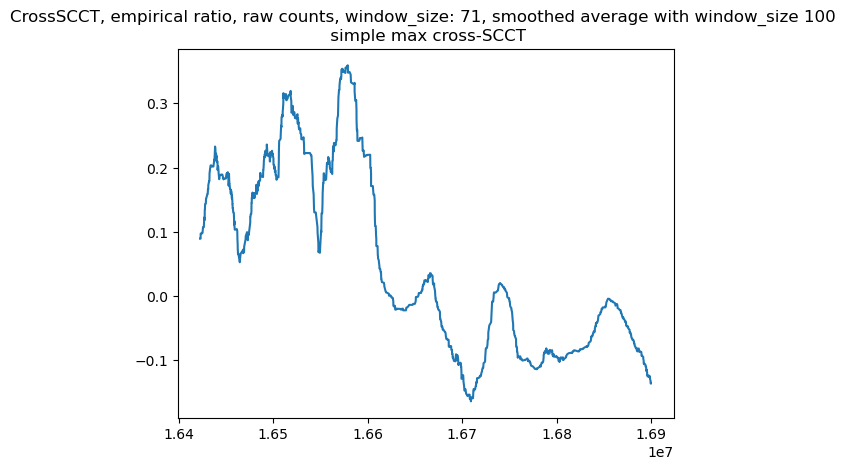

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

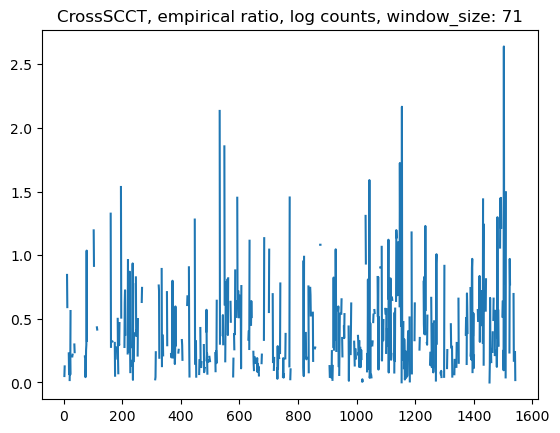

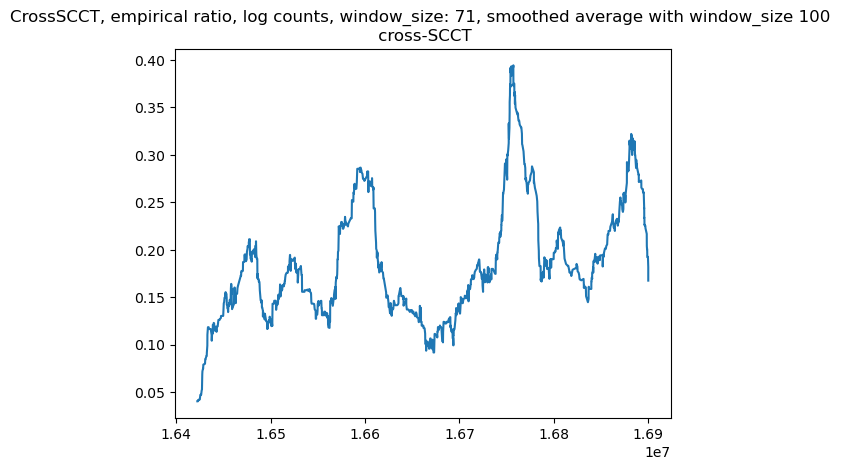

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

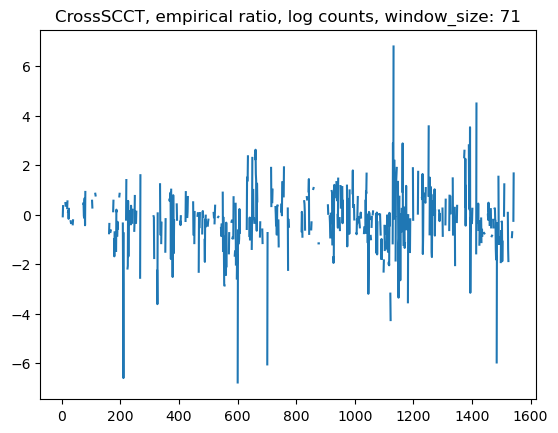

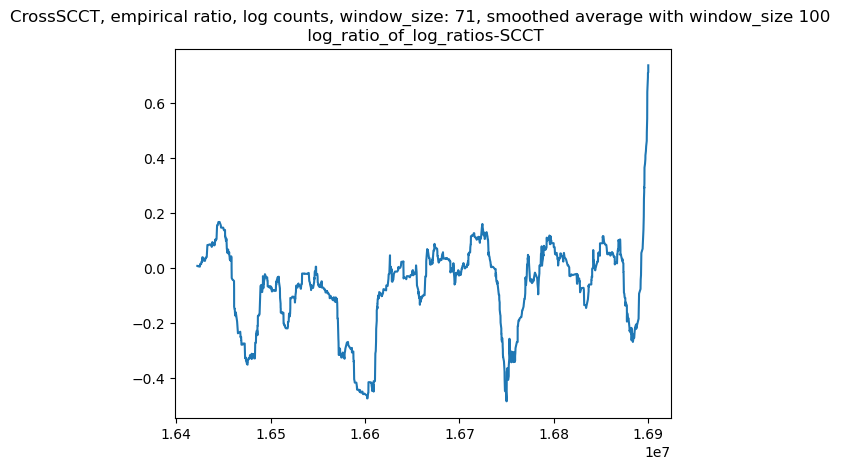

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

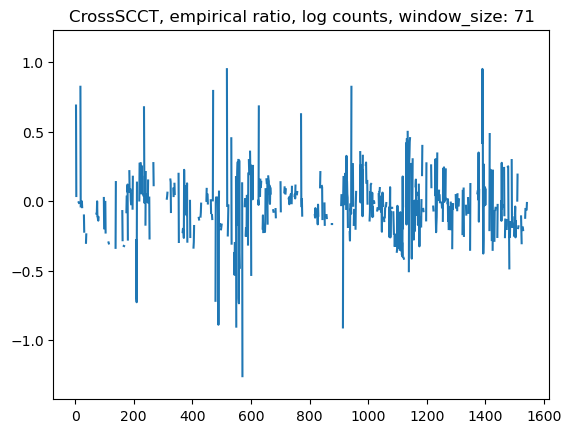

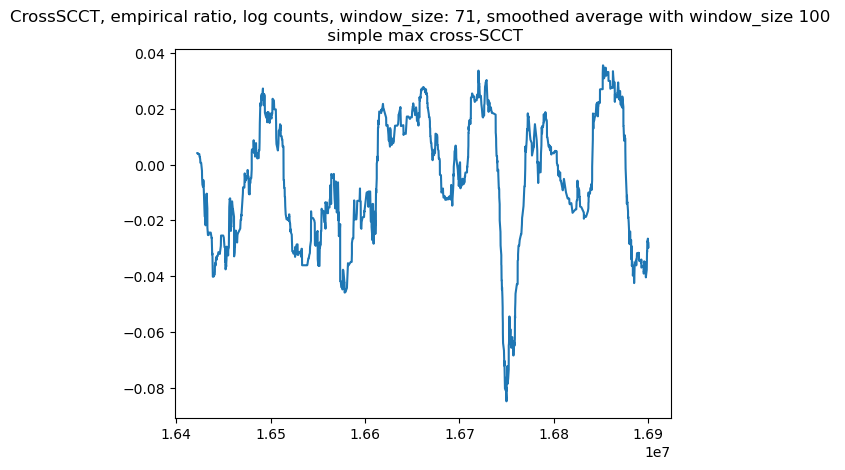

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

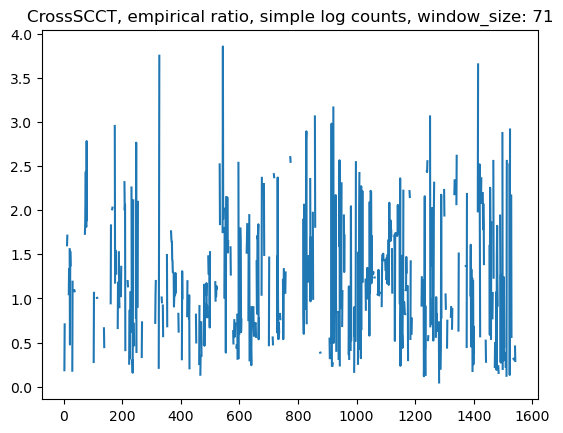

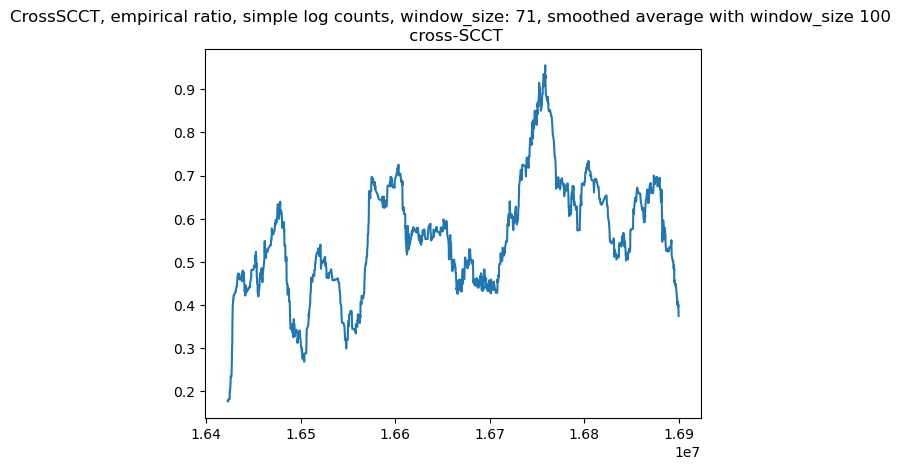

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

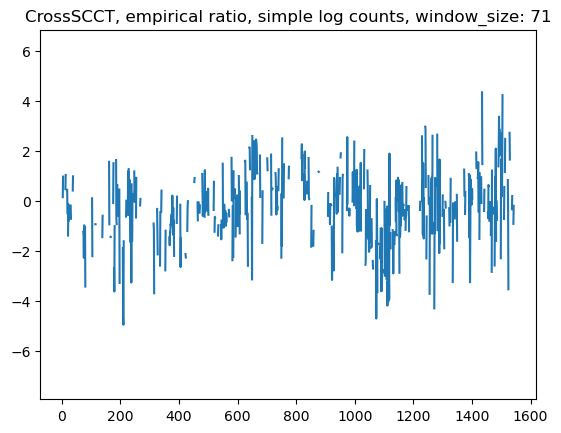

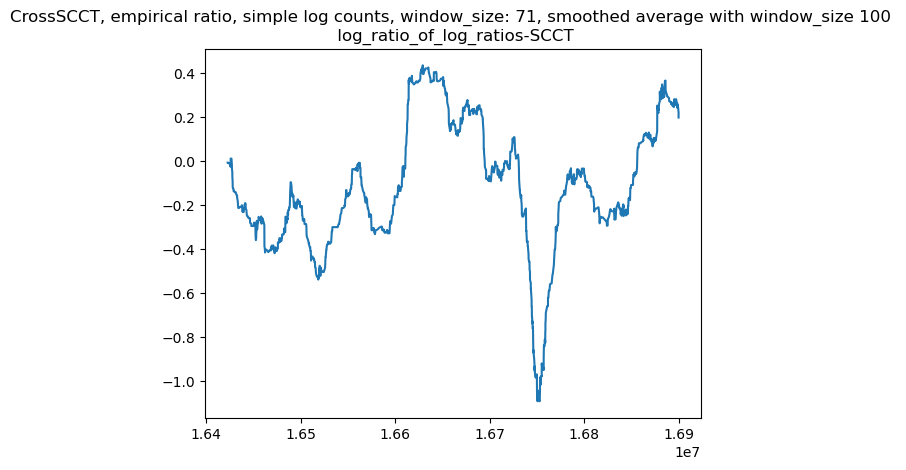

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

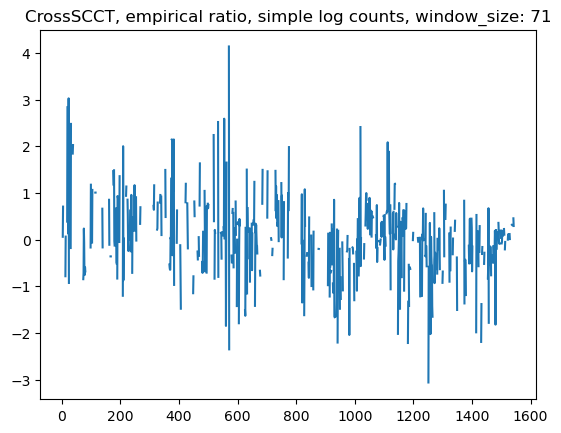

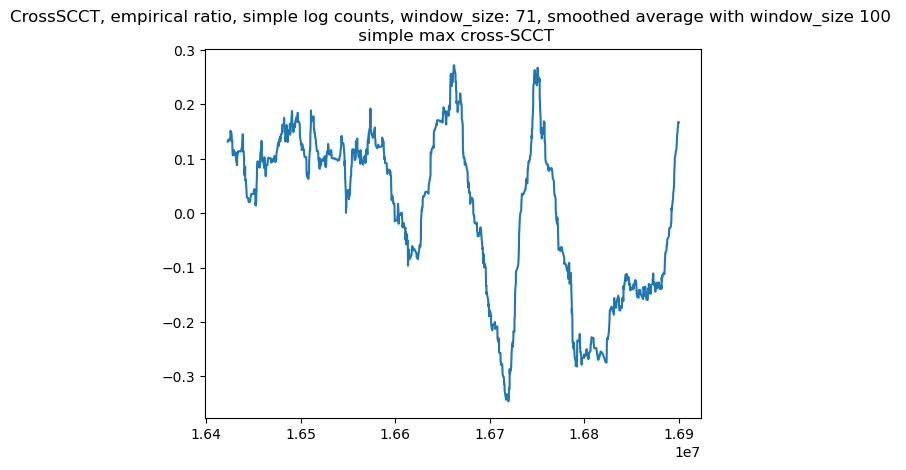

In [20]:
## raw counts
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, raw counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, raw counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n cross-SCCT")
plt.show()
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, log_ratio_of_log_ratios=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, raw counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, raw counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n log_ratio_of_log_ratios-SCCT")
plt.show()

snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, simple_max=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, raw counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, raw counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n simple max cross-SCCT")
plt.show()


## full log counts (with Yates-correction)
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered,  use_log_ratio=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n cross-SCCT")
plt.show()


snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, log_ratio_of_log_ratios=True, use_log_ratio=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n log_ratio_of_log_ratios-SCCT")
plt.show()

snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, simple_max=True,  use_log_ratio=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n simple max cross-SCCT")
plt.show()


## simple log counts
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered,  use_log_ratio=True, simple_log_ratio=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, simple log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, simple log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n cross-SCCT")
plt.show()


snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, log_ratio_of_log_ratios=True, use_log_ratio=True, simple_log_ratio=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, simple log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, simple log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n log_ratio_of_log_ratios-SCCT")
plt.show()


snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, simple_max=True,  use_log_ratio=True, simple_log_ratio=True,  set_alpha_1=False, theoretical=False)
    cross_res.append(result)
	

plt.plot(cross_res)
plt.title(f"CrossSCCT, empirical ratio, simple log counts, window_size: {snp_window_size}")
plt.show()

smooth_window_size = 100
smoothed_unst = smooth_average(cross_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_unst)
plt.title(f"CrossSCCT, empirical ratio, simple log counts, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size} \n simple max cross-SCCT")
plt.show()

## Show values for ancestral and derived SCCT between both populations

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

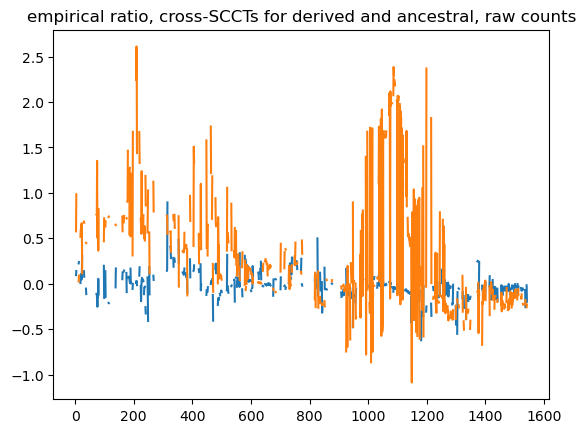

Text(0.5, 1.0, 'Empirical ratio, raw counts, cross-SCCTs for derived and ancestral, window_size: 71, smoothed average with window_size 100')

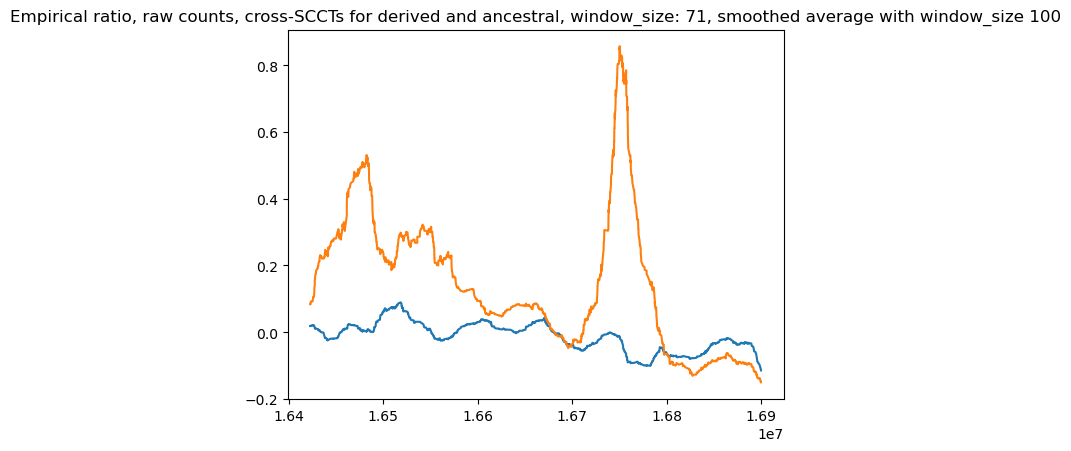

In [22]:
## raw counts
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

cross_res = []

for i in range(len(snp_slides_tgt)):
    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]
    result = cross_scct(gts1_window=snp_window_ref, gts2_window=snp_window_tgt, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered,  set_alpha_1=False, theoretical=False, return_multiple_values=True)
    cross_res.append(result)


first_values = []
second_values = []

for item in cross_res:
    if isinstance(item, tuple):
        first_values.append(item[0])
        second_values.append(item[1])
    else:
        first_values.append(float('nan'))
        second_values.append(float('nan'))

plt.plot(first_values)
plt.plot(second_values)
plt.title("empirical ratio, cross-SCCTs for derived and ancestral, raw counts")
	
plt.show()

smooth_window_size = 100
smoothed_res1 = smooth_average(first_values, window_size=smooth_window_size)
smoothed_res2 = smooth_average(second_values, window_size=smooth_window_size)

plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_res1)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_res2)
plt.title(f"Empirical ratio, raw counts, cross-SCCTs for derived and ancestral, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size}")


# Finally, standard calculation with difference

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

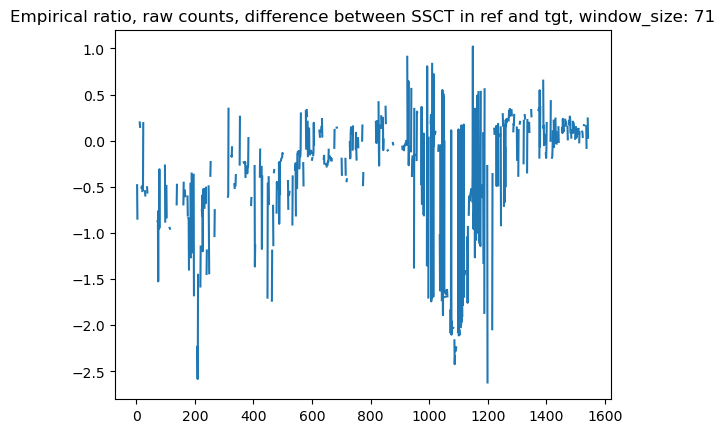

Text(0.5, 1.0, 'Empirical ratio, raw counts, difference between SSCT in ref and tgt, window_size: 71, smoothed average with window_size 100')

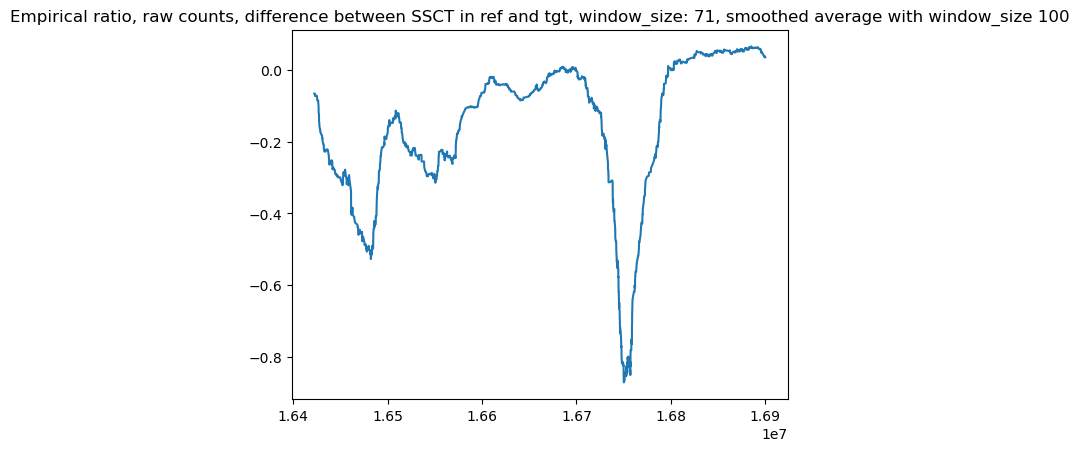

In [34]:
## raw counts
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

diff_scct_res = []

for i in range(len(snp_slides_tgt)):

    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]

    diff_scct = cross_scct_diff(snp_window_ref, snp_window_tgt, theoretical=False, use_log_ratio=False, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, set_alpha_1=False)   
    diff_scct_res.append(diff_scct)

plt.plot(diff_scct_res)
plt.title(f"Empirical ratio, raw counts, difference between SSCT in ref and tgt, window_size: {snp_window_size}")
plt.show() 

smooth_window_size = 100
smoothed_diff_scct_res = smooth_average(diff_scct_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_diff_scct_res)

plt.title(f"Empirical ratio, raw counts, difference between SSCT in ref and tgt, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size}")

Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the central SNP, return nan
Error: There is either only the ancestral or the derived allel present at the cent

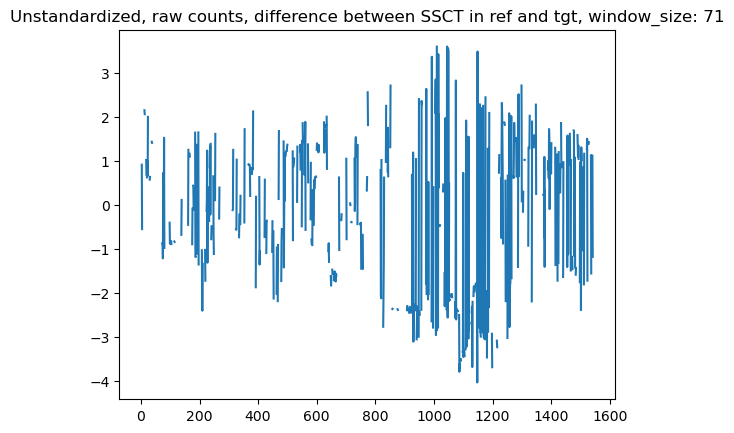

Text(0.5, 1.0, 'Unstandardized, raw counts, difference between SSCT in ref and tgt, window_size: 71, smoothed average with window_size 100')

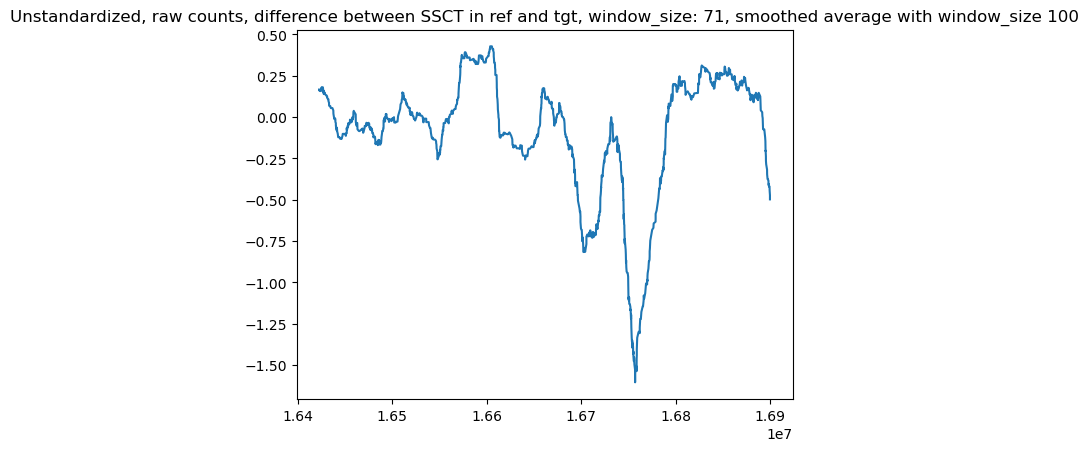

In [36]:
snp_window_size = 71    
snp_slides_tgt = sliding_window_view(full_vcf_tgt_gts_filtered, window_shape=(snp_window_size, full_vcf_tgt_gts_filtered.shape[1]))
snp_slides_ref = sliding_window_view(full_vcf_ref_gts_filtered, window_shape=(snp_window_size, full_vcf_ref_gts_filtered.shape[1]))

pos_slides = sliding_window_view(full_vcf_pos_filtered, window_shape=(snp_window_size))

diff_scct_res = []

for i in range(len(snp_slides_tgt)):

    snp_window_ref = snp_slides_ref[i][0]
    snp_window_tgt = snp_slides_tgt[i][0]
    pos_window = pos_slides[i]

    diff_scct = cross_scct_diff(snp_window_ref, snp_window_tgt, theoretical=False, use_log_ratio=False, positions_window=pos_window, full_vcf_gts1=full_vcf_ref_gts_filtered, full_vcf_gts2=full_vcf_tgt_gts_filtered, full_vcf_pos=full_vcf_pos_filtered, set_alpha_1=True)   
    diff_scct_res.append(diff_scct)

plt.plot(diff_scct_res)
plt.title(f"Unstandardized, raw counts, difference between SSCT in ref and tgt, window_size: {snp_window_size}")
plt.show() 

smooth_window_size = 100
smoothed_diff_scct_res = smooth_average(diff_scct_res, window_size=smooth_window_size)
plt.plot(full_vcf_pos_filtered[snp_window_size-1:], smoothed_diff_scct_res)

plt.title(f"Unstandardized, raw counts, difference between SSCT in ref and tgt, window_size: {snp_window_size}, smoothed average with window_size {smooth_window_size}")